<a href="https://colab.research.google.com/github/jb-apps/U-2-Net/blob/master/CoreML%20Conversion-U2NETP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install coremltools

     |████████████████████████████████| 3.4MB 4.5MB/s 
  Created wheel for attr: filename=attr-0.3.1-cp37-none-any.whl size=2458 sha256=e13e2c50b64ee72a2b9753ae926233d76dfa49ba4c2f89faf4ee7a1397cfa566
  Stored in directory: /root/.cache/pip/wheels/f0/96/9b/1f8892a707d17095b5a6eab0275da9d39e68e03a26aee2e726
Successfully built attr


In [3]:
# Initialise packages 
from u2net import U2NETP
import coremltools as ct
from coremltools.proto import FeatureTypes_pb2 as ft
import torch
import os
from PIL import Image
from torchvision import transforms

In [ ]:
# Initialise our model.
net = U2NETP(3,1)
device = torch.device('cpu')
net.load_state_dict(torch.load("u2netp.pth", map_location=device))
net.cpu()
net.eval()

torch.Size([1, 3, 320, 320])


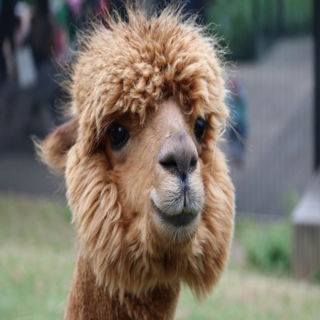

In [6]:
# Create a test input.

# Specify an image as input here
input_image = Image.open("0003.jpg").resize((320,320))
example_input = transforms.ToTensor()(input_image).unsqueeze_(0)
example_input = example_input.type(torch.FloatTensor)

print(example_input.shape)
display(input_image)

# or uncomment the below line to use a random Tensor instead.
# example_input = torch.rand(1,3,320,320)

In [6]:
def normPRED(d):
    ma = torch.max(d)
    mi = torch.min(d)
    dn = (d-mi)/(ma-mi)
    return dn

In [9]:
d1,d2,d3,d4,d5,d6,d7 = net(example_input)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [10]:
print(d1.shape)
print(d1[0][0][0][:5])

torch.Size([1, 1, 320, 320])
tensor([3.5586e-04, 1.7481e-04, 1.0477e-04, 2.0024e-05, 7.5615e-06],
       grad_fn=<SliceBackward>)


In [37]:
pred = d1[:,0,:,:]
#pred = normPRED(pred)

In [11]:
from torchvision import transforms

def save_output(pred, image):
  print(pred.shape)
  predict = pred
  predict = predict.squeeze()
  print(predict.shape)
  predict_np = predict.cpu().data.numpy()
  im = Image.fromarray(predict_np * 255).convert('LA')
  imo = im.resize((image.size[0],image.size[1]),resample=Image.BILINEAR)
    
  display(imo)

torch.Size([1, 1, 320, 320])
torch.Size([320, 320])


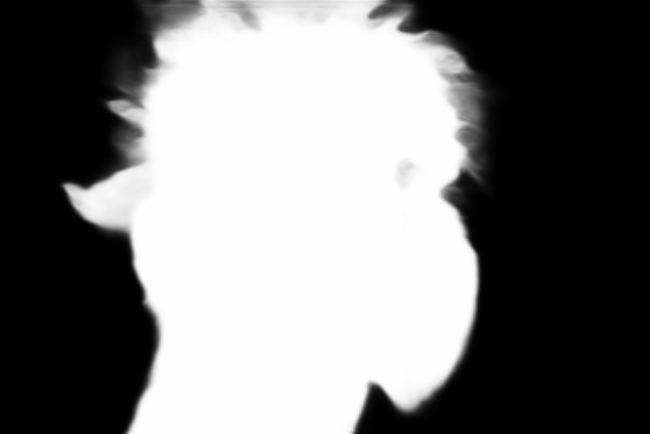

'\nsave_output(d2, Image.open("0003.jpg"))\nsave_output(d3, Image.open("0003.jpg"))\nsave_output(d4, Image.open("0003.jpg"))\nsave_output(d5, Image.open("0003.jpg"))\nsave_output(d6, Image.open("0003.jpg"))\nsave_output(d7, Image.open("0003.jpg"))\n'

In [12]:
save_output(d1, Image.open("0003.jpg"))
'''
save_output(d2, Image.open("0003.jpg"))
save_output(d3, Image.open("0003.jpg"))
save_output(d4, Image.open("0003.jpg"))
save_output(d5, Image.open("0003.jpg"))
save_output(d6, Image.open("0003.jpg"))
save_output(d7, Image.open("0003.jpg"))
'''

In [28]:
# Trace and convert the model.
traced_model = torch.jit.trace(net, example_input)
_inputs = ct.ImageType(name= "input_1", shape= example_input.shape, scale= 1/255.0)
model = ct.convert(traced_model, inputs=[_inputs])

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Translating MIL ==> MLModel Ops: 100%|██████████| 1977/1977 [00:00<00:00, 8843.51 ops/s]


In [29]:
# Add metadata
model.short_description = "U2-Net: Going Deeper with Nested U-Structure for Salient Object Detection"
model.license = "Apache 2.0"
model.author = "Qin, Xuebin and Zhang, Zichen and Huang, Chenyang and Dehghan, Masood and Zaiane, Osmar and Jagersand, Martin"

In [30]:
# Rename inputs
spec = model.get_spec()
ct.utils.rename_feature(spec, "input_1", "in_0")
ct.utils.rename_feature(spec,"2169","out_a0")
ct.utils.rename_feature(spec,"2170","out_a1")
ct.utils.rename_feature(spec,"2171","out_a2")
ct.utils.rename_feature(spec,"2172","out_a3")
ct.utils.rename_feature(spec,"2173","out_a4")
ct.utils.rename_feature(spec,"2174","out_a5")
ct.utils.rename_feature(spec,"2175","out_a6")
model = ct.models.MLModel(spec)
model.save("u2net_temp.mlmodel")

In [31]:
# Re-open model for modification
model = ct.models.MLModel("u2net_temp.mlmodel")
spec = model.get_spec()
spec_layers = getattr(spec, spec.WhichOneof("Type")).layers
output_layers = spec_layers[476:] # Get only the last output layers, may change with full-size U^2net

In [26]:
print(spec_layers[0])

name: "input.2"
input: "in_0"
output: "input.2"
convolution {
  outputChannels: 64
  kernelChannels: 3
  nGroups: 1
  kernelSize: 3
  kernelSize: 3
  stride: 1
  stride: 1
  dilationFactor: 1
  dilationFactor: 1
  valid {
    paddingAmounts {
      borderAmounts {
        startEdgeSize: 1
        endEdgeSize: 1
      }
      borderAmounts {
        startEdgeSize: 1
        endEdgeSize: 1
      }
    }
  }
  hasBias: true
  weights {
    floatValue: 0.5763563513755798
    floatValue: 1.5805026292800903
    floatValue: 1.5842729806900024
    floatValue: 0.7455283403396606
    floatValue: 1.9967870712280273
    floatValue: 1.9587031602859497
    floatValue: 0.1900143027305603
    floatValue: 1.214145302772522
    floatValue: 1.3133448362350464
    floatValue: -0.641427755355835
    floatValue: -0.07922600209712982
    floatValue: -0.11519651114940643
    floatValue: -0.7265791893005371
    floatValue: -0.39872920513153076
    floatValue: 0.036658186465501785
    floatValue: -0.77943724393

In [20]:
print(output_layers[0])

name: "2169"
input: "input"
output: "out_a0"
activation {
  sigmoid {
  }
}



In [32]:
# Append new layers
new_layers = []
layernum = 0;
for layer in output_layers:
    new_layer = spec_layers.add()
    new_layer.name = 'out_p' + str(layernum)
    new_layers.append('out_p' + str(layernum))

    new_layer.activation.linear.alpha = 255
    new_layer.activation.linear.beta = 0

    new_layer.input.append('out_a' + str(layernum))
    new_layer.output.append('out_p' + str(layernum))
    output_description = next(x for x in spec.description.output if x.name==output_layers[layernum].output[0])
    output_description.name = new_layer.name

    layernum = layernum + 1

In [33]:
# Specify the outputs as grayscale images.
for output in spec.description.output: 
    if output.name not in new_layers: 
        continue
    if output.type.WhichOneof('Type') != 'multiArrayType': 
        raise ValueError("%s is not a multiarray type" % output.name) 

    array_shape = tuple(output.type.multiArrayType.shape) 
    # print(array_shape)
    # print(output.type)


    output.type.imageType.colorSpace = ft.ImageFeatureType.ColorSpace.Value('GRAYSCALE')
    output.type.imageType.width = 320 
    output.type.imageType.height = 320

In [35]:
updated_model = ct.models.MLModel(spec)
model.short_description = "U2-Net: Going Deeper with Nested U-Structure for Salient Object Detection"
model.license = "Apache 2.0"
model.author = "Qin, Xuebin and Zhang, Zichen and Huang, Chenyang and Dehghan, Masood and Zaiane, Osmar and Jagersand, Martin"
model_file_name = 'updated_model.mlmodel'
updated_model.save(model_file_name)


In [36]:
# Save our new model
updated_model = ct.models.MLModel(spec)
updated_model.save("u2netp.mlmodel")

In [ ]:
# Test our model.
out_dict = updated_model.predict({'in_0': input_image})
for key,value in out_dict.items():
    value.save(key+".png")

Exception: ignored